# Modelling different aspects of Trust

In [7]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def plots(ols_model_robust):
    # Residuals from the model
    residuals = ols_model_robust.resid
 
    # Predicted values from the model
    fitted_values = ols_model_robust.fittedvalues

    # 1. Residuals vs. Fitted Plot
    plt.figure(figsize=(8, 6))
    sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

    # 2. Q-Q Plot
    sm.qqplot(residuals, line='45', fit=True)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

    # 3. Histogram of Residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, color='blue')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


In [3]:
def vif(X_const):
    vif = pd.DataFrame()
    vif["Variable"] = X_const.columns
    vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    print(vif)

# Germany only

In [49]:
df = pd.read_csv('data/wvs/wave7.csv')

# Define the list of countries to include
countries_to_keep = ['DEU']
# Filter the DataFrame
df = df[df['B_COUNTRY_ALPHA'].isin(countries_to_keep)].copy()

C:\Users\Carsten\AppData\Local\Temp\ipykernel_24880\597167731.py:1: DtypeWarning: Columns (582,583,584) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wvs/wave7.csv')


In [65]:
trust = ['base_distrust_index', 'national_distrust_index', 'international_distrust_index']

correlation_matrix = df[trust].corr()
correlation_matrix

,base_distrust_index,national_distrust_index,international_distrust_index
base_distrust_index,1.000000,0.388035,0.314003
national_distrust_index,0.388035,1.000000,0.694035
international_distrust_index,0.314003,0.694035,1.000000


## Baseline distrust

In [11]:
ref_dummy_for_pol_ref = 5
regressors = [# corruption
              "group_corruption",
              
              # migration
              "is_immigrant",
              "mother_immigrant",
              "father_immigrant",
              "migration_positive",
              "migration_negative",
              
              # political preference
              *[f"pol_value_{i}" for i in range(1,11) if i != ref_dummy_for_pol_ref],
              
              # hardships and security
              "hardships_questions",
              "security_neighborhood",
              "security_financial",
              "security_war",
              
              # demographics (including happiness)
              "age",
              "gender",
              "above_avg_inc",
              "happ__1",
              "happ__3",
              "happ__4"
              ]

In [12]:
X = df.loc[:, regressors]
y = df['base_distrust_index']

### Robust OLS

In [88]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                             OLS Regression Results                            
Dep. Variable:     base_distrust_index   R-squared:                       0.217
Model:                             OLS   Adj. R-squared:                  0.215
Method:                  Least Squares   F-statistic:                     113.1
Date:                 Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                         15:50:34   Log-Likelihood:                 6761.7
No. Observations:                10712   AIC:                        -1.348e+04
Df Residuals:                    10688   BIC:                        -1.330e+04
Df Model:                           23                                         
Covariance Type:                   HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [156]:
# get coefficients
def append_star(row):
  p_val = row["p-Value"]
  est = row["Estimate"]
  if p_val < 0.001:
    return f"{est}***"
  if p_val < 0.01:
    return f"{est}**"
  if p_val < 0.05:
    return f"{est}*"
  return est 

def apa_latex_est_tablular(lm):
  """
  Make sure to correct placement inside of the columns to {cc..} and add an appropriate label
  """
  # first create a dataframe with all the entries
  results_table = pd.DataFrame({"Estimate": round(lm.params,3).astype("str"),
                              "Standard-Deviation": round(lm.HC0_se, 3).astype("str"),
                              r"$T_{H_0:\beta=0}$": round(lm.tvalues, 3).astype("str"),
                              "p-Value": round(lm.pvalues, 3)})
  
  # then append significant stars
  results_table["Estimate"] = results_table.apply(lambda row: append_star(row), axis=1)
  # then remove leading zero from p-values
  results_table["p-Value"] = results_table["p-Value"].astype("str").str.lstrip("0")
  

  results_table.loc[results_table["p-Value"] == ".0", ["p-Value"]] = "<.001"
  results_table.loc[results_table["Standard-Deviation"] == "0.0", ["Standard-Deviation"]] = "<0.001"
  
  # make features formatted columns formatted correctly
  results_table.index = [r"\texttt {" + key.replace("_", r"\_") + "}" for key in results_table.index]

  print(results_table.to_latex())

In [157]:
apa_latex_est_tablular(ols_model_robust)

\begin{tabular}{lllll}
\toprule
 & Estimate & Standard-Deviation & $T_{H_0:\beta=0}$ & p-Value \\
\midrule
\texttt {const} & 0.411*** & 0.011 & 37.428 & <.001 \\
\texttt {group\_corruption} & 0.147*** & 0.011 & 13.064 & <.001 \\
\texttt {is\_immigrant} & 0.008 & 0.005 & 1.618 & .106 \\
\texttt {mother\_immigrant} & 0.002 & 0.005 & 0.447 & .655 \\
\texttt {father\_immigrant} & 0.015** & 0.005 & 3.01 & .003 \\
\texttt {migration\_positive} & -0.052*** & 0.005 & -9.511 & <.001 \\
\texttt {migration\_negative} & 0.037*** & 0.003 & 11.115 & <.001 \\
\texttt {pol\_value\_1} & -0.017** & 0.007 & -2.64 & .008 \\
\texttt {pol\_value\_2} & -0.034*** & 0.006 & -5.888 & <.001 \\
\texttt {pol\_value\_3} & -0.026*** & 0.004 & -6.397 & <.001 \\
\texttt {pol\_value\_4} & -0.02*** & 0.004 & -4.6 & <.001 \\
\texttt {pol\_value\_6} & -0.004 & 0.004 & -0.894 & .371 \\
\texttt {pol\_value\_7} & -0.013** & 0.005 & -2.811 & .005 \\
\texttt {pol\_value\_8} & -0.023*** & 0.005 & -4.906 & <.001 \\
\texttt {pol\

In [69]:
from statsmodels.stats.diagnostic import het_breuschpagan
residuals = ols_model_robust.resid


bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange multiplier statistic': 61.53561805945283, 'p-value': 0.002632297862366786, 'f-value': 1.843491872820319, 'f p-value': 0.002316006030655372}


In [ ]:
vif(X_const)

                      Variable         VIF
0                        const  212.091176
1          baseline_corruption    1.425903
2             group_corruption    1.376187
3         migration_perception    1.352547
4           migration_positive    1.230198
5           migration_negative    1.252014
6                     pol_pref    1.150121
7                       gender    1.427024
8                          age    1.739399
9             mother_immigrant    2.531751
10            father_immigrant    3.066402
11                is_immigrant    3.134467
12     standard_parents_better    1.327795
13      standard_parents_worse    1.332898
14          baseline_happiness    1.553446
15                      health    1.390405
16                     freedom    1.241270
17       baseline_satisfaction    1.948135
18      financial_satisfaction    1.905437
19         hardships_questions    1.321545
20   security_actions_money_no    1.199023
21   security_actions_night_no    1.364753
22  securit

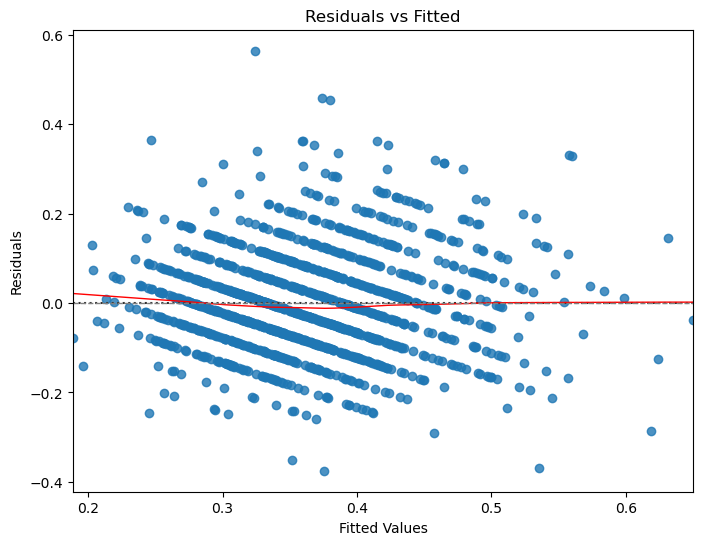

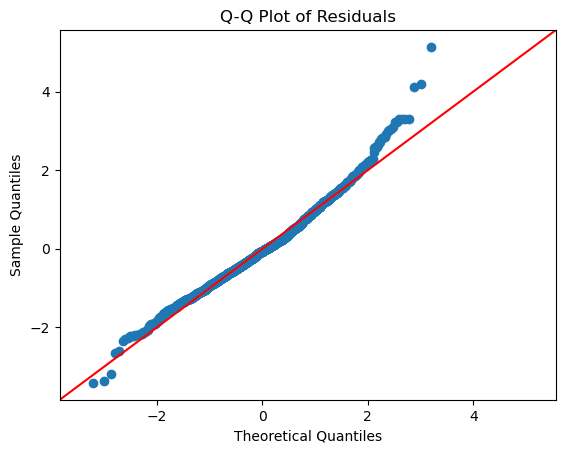

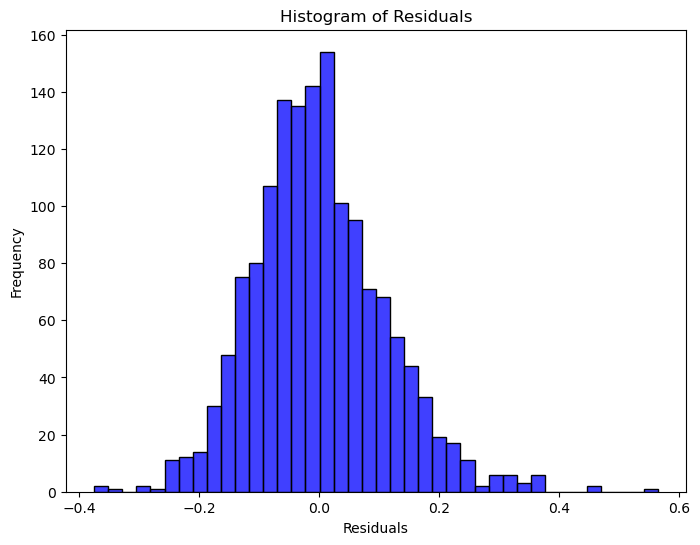

In [9]:
plots(ols_model_robust)

## National distrust

In [14]:
X = df.loc[:, regressors]
y = df['national_distrust_index']

In [15]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                               OLS Regression Results                              
Dep. Variable:     national_distrust_index   R-squared:                       0.219
Model:                                 OLS   Adj. R-squared:                  0.205
Method:                      Least Squares   F-statistic:                     13.14
Date:                     Mon, 10 Feb 2025   Prob (F-statistic):           3.55e-48
Time:                             14:12:45   Log-Likelihood:                 1032.0
No. Observations:                     1356   AIC:                            -2012.
Df Residuals:                         1330   BIC:                            -1877.
Df Model:                               25                                         
Covariance Type:                       HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [56]:
from statsmodels.stats.stattools import durbin_watson

residuals = ols_model_robust.resid

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.925033640535073


In [76]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange multiplier statistic': 61.53561805945283, 'p-value': 0.002632297862366786, 'f-value': 1.843491872820319, 'f p-value': 0.002316006030655372}


In [57]:
vif(X_const)

                 Variable         VIF
0                   const  125.711137
1        group_corruption    1.074267
2      migration_positive    1.225256
3      migration_negative    1.214992
4             pol_value_1    1.090954
5             pol_value_2    1.115768
6             pol_value_3    1.268374
7             pol_value_4    1.274610
8             pol_value_6    1.265138
9             pol_value_7    1.160249
10            pol_value_8    1.103777
11            pol_value_9    1.024440
12           pol_value_10    1.045324
13    hardships_questions    1.165836
14  security_neighborhood    1.193903
15     security_financial    1.486315
16           security_war    1.282623
17                    age    1.370953
18                 gender    1.049355
19       mother_immigrant    2.220802
20       father_immigrant    2.625679
21           is_immigrant    2.672016
22          above_avg_inc    1.104259
23          above_avg_hap    1.039632


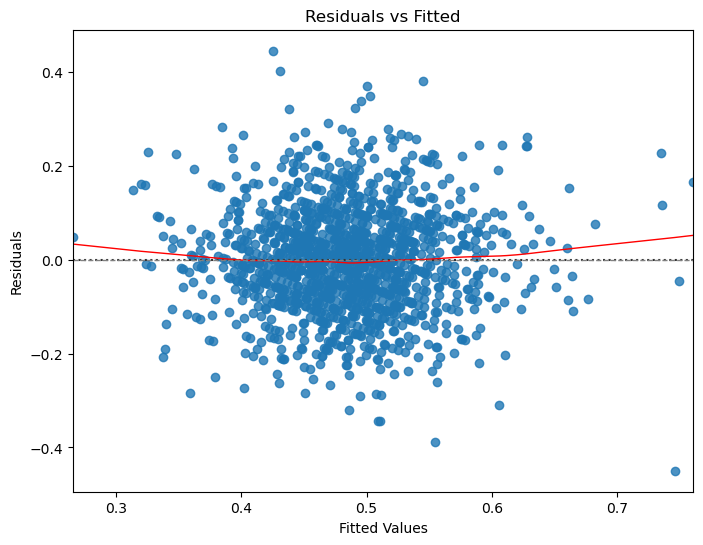

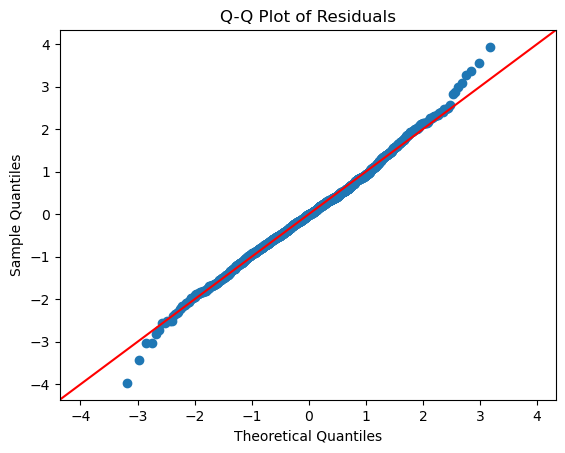

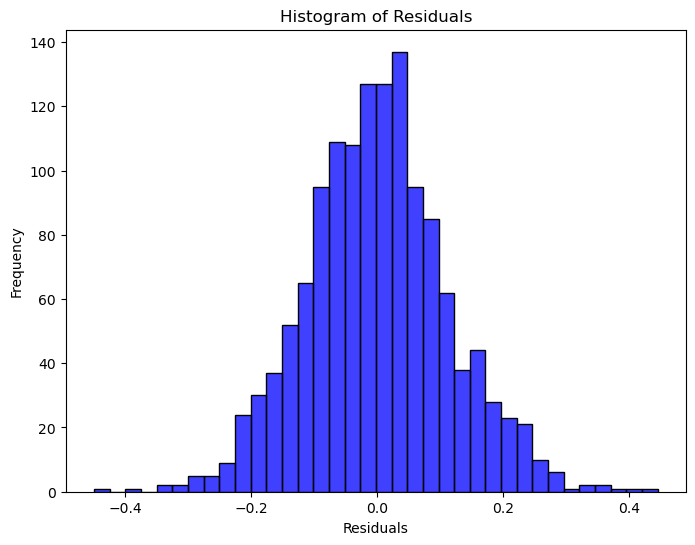

In [58]:
plots(ols_model_robust)

## International distrust

In [14]:
X = df.loc[:, 'baseline_corruption':]
y = df['international_distrust_index']
#X['base_distrust_index'] = df['base_distrust_index']

In [15]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                                 OLS Regression Results                                 
Dep. Variable:     international_distrust_index   R-squared:                       0.225
Model:                                      OLS   Adj. R-squared:                  0.207
Method:                           Least Squares   F-statistic:                     10.79
Date:                          Tue, 21 Jan 2025   Prob (F-statistic):           2.71e-50
Time:                                  12:48:08   Log-Likelihood:                 781.38
No. Observations:                          1490   AIC:                            -1493.
Df Residuals:                              1455   BIC:                            -1307.
Df Model:                                    34                                         
Covariance Type:                            HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

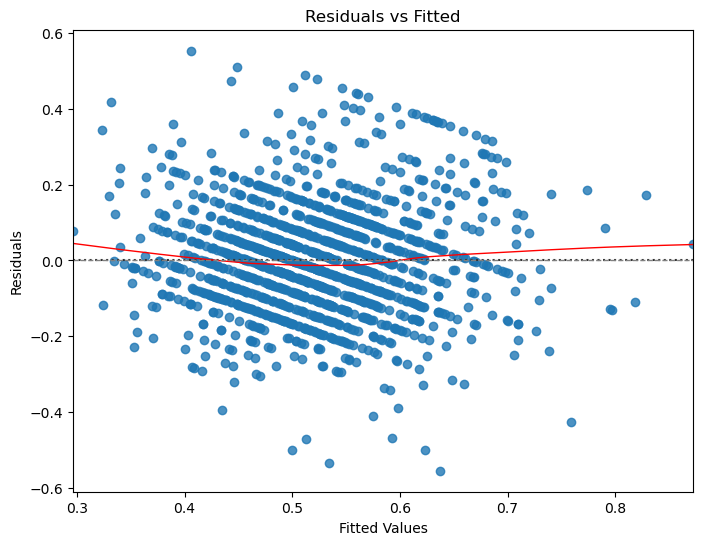

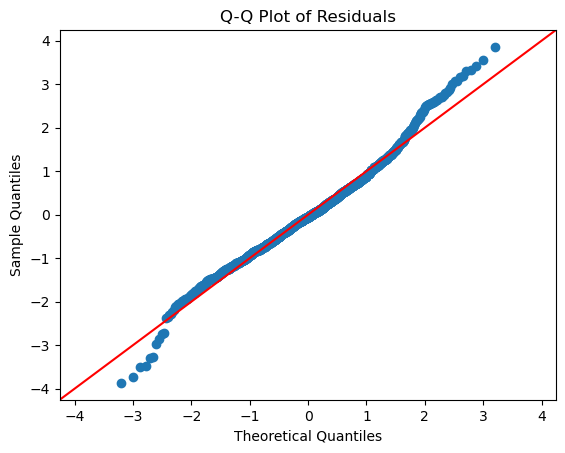

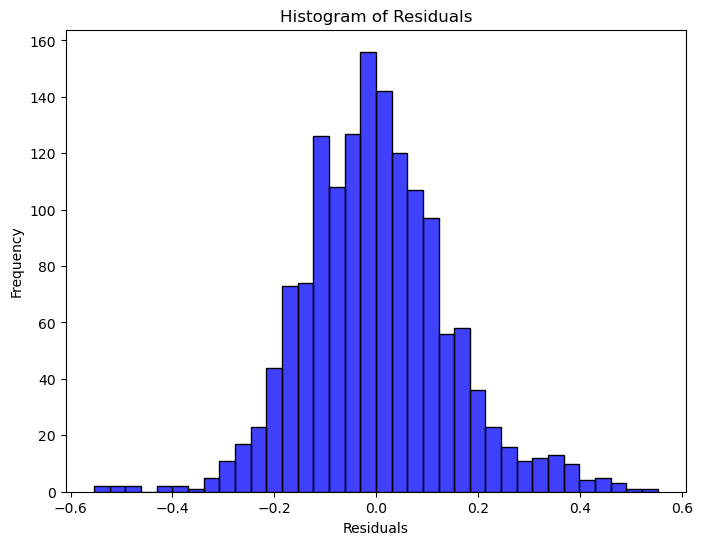

In [16]:
plots(ols_model_robust)

# Now add country dummies

In [78]:
df = pd.read_csv('data/wvs/wave7.csv')

# Define the list of countries to include
countries_to_keep = ['AUS','CAN','DEU','NLD','USA']
# Filter the DataFrame
df = df[df['B_COUNTRY_ALPHA'].isin(countries_to_keep)].copy()

C:\Users\Carsten\AppData\Local\Temp\ipykernel_24880\1574816901.py:1: DtypeWarning: Columns (582,583,584) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wvs/wave7.csv')


In [79]:
dummies = pd.get_dummies(df['B_COUNTRY_ALPHA'], prefix='country').astype(int)
df = pd.concat([df, dummies], axis=1)
# drop reference class
df = df.drop(['country_DEU'], axis=1)
country_dummies = dummies.columns.drop("country_DEU")

## Baseline Trust

In [13]:
X = df.loc[:, [*regressors, *country_dummies]]
y = df['base_distrust_index']

NameError: name 'country_dummies' is not defined

In [82]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                             OLS Regression Results                            
Dep. Variable:     base_distrust_index   R-squared:                       0.253
Model:                             OLS   Adj. R-squared:                  0.252
Method:                  Least Squares   F-statistic:                     122.1
Date:                 Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                         15:43:07   Log-Likelihood:                 7016.9
No. Observations:                10712   AIC:                        -1.398e+04
Df Residuals:                    10684   BIC:                        -1.377e+04
Df Model:                           27                                         
Covariance Type:                   HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [21]:
vif(X_const)

                      Variable         VIF
0                        const  146.808569
1          baseline_corruption    1.452427
2             group_corruption    1.324739
3         migration_perception    1.449763
4           migration_positive    1.425862
5           migration_negative    2.550300
6                     pol_pref    1.201273
7                       gender    1.283385
8                          age    1.584664
9             mother_immigrant    1.635429
10            father_immigrant    2.748770
11                is_immigrant    2.729616
12     standard_parents_better    1.359834
13      standard_parents_worse    1.447531
14          baseline_happiness    1.735640
15                      health    1.436430
16                     freedom    1.537951
17       baseline_satisfaction    2.484654
18      financial_satisfaction    2.074762
19         hardships_questions    1.704850
20   security_actions_money_no    1.221247
21   security_actions_night_no    1.362248
22  securit

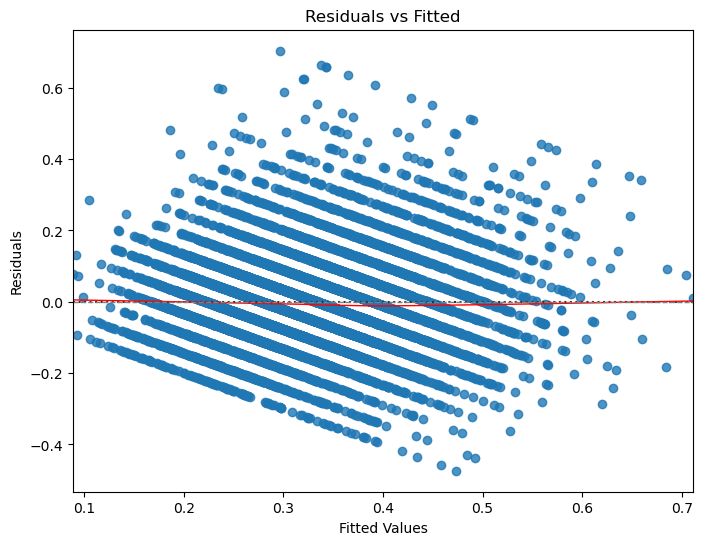

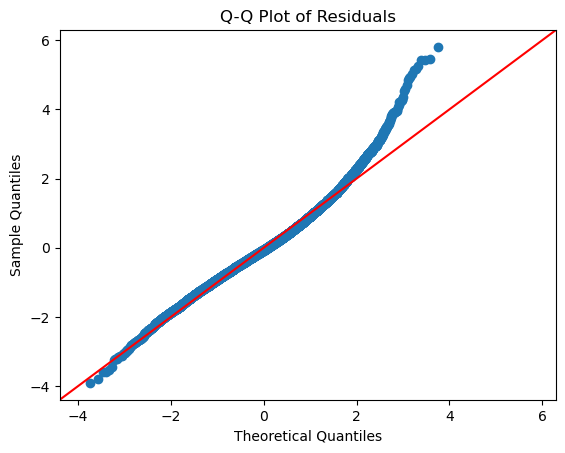

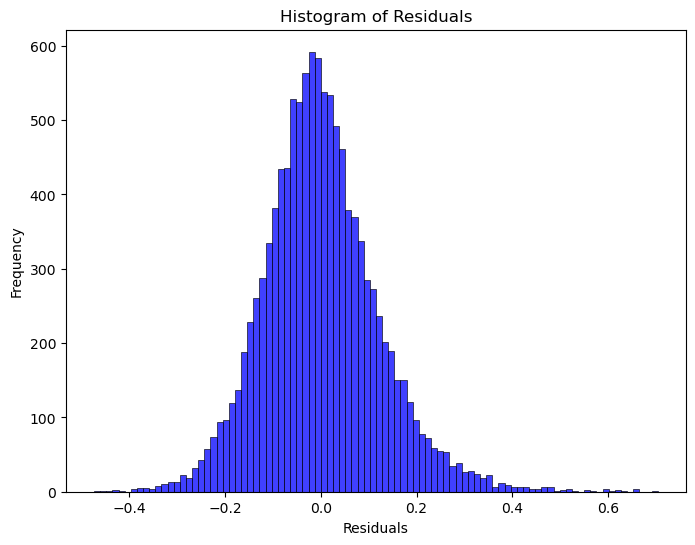

In [22]:
plots(ols_model_robust)

## National distrust

In [83]:
X = df[[*regressors, *country_dummies]]
y = df['national_distrust_index']

In [84]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                               OLS Regression Results                              
Dep. Variable:     national_distrust_index   R-squared:                       0.221
Model:                                 OLS   Adj. R-squared:                  0.219
Method:                      Least Squares   F-statistic:                     96.54
Date:                     Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                             15:44:03   Log-Likelihood:                 6770.2
No. Observations:                    10712   AIC:                        -1.348e+04
Df Residuals:                        10684   BIC:                        -1.328e+04
Df Model:                               27                                         
Covariance Type:                       HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

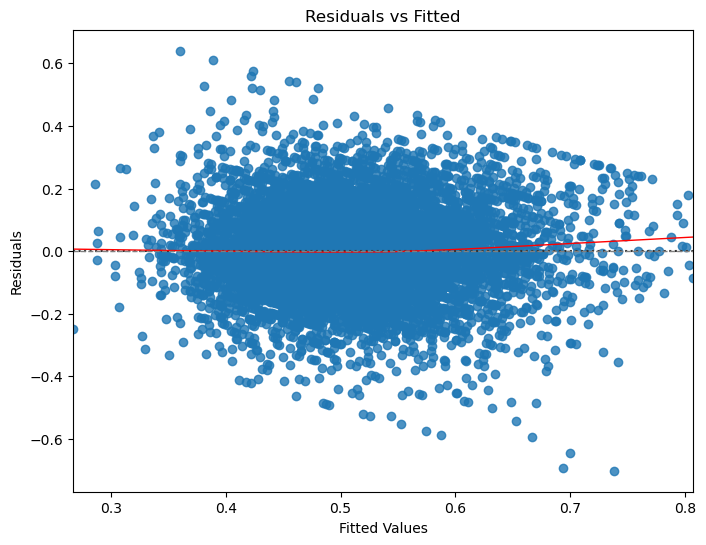

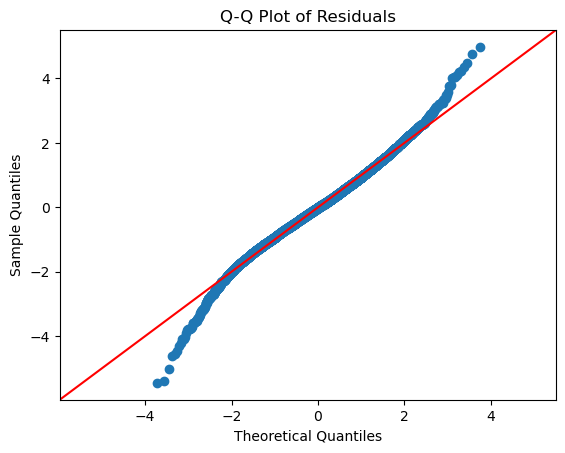

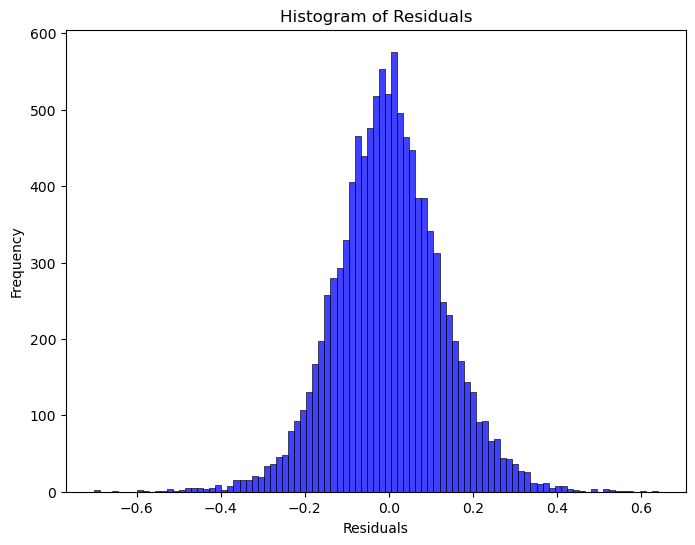

In [85]:
plots(ols_model_robust)

## International distrust

In [26]:
X = df.loc[:, 'baseline_corruption':]
y = df['international_distrust_index']

In [27]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                                 OLS Regression Results                                 
Dep. Variable:     international_distrust_index   R-squared:                       0.263
Model:                                      OLS   Adj. R-squared:                  0.260
Method:                           Least Squares   F-statistic:                     103.9
Date:                          Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                                  12:48:53   Log-Likelihood:                 4431.4
No. Observations:                         11512   AIC:                            -8785.
Df Residuals:                             11473   BIC:                            -8498.
Df Model:                                    38                                         
Covariance Type:                            HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

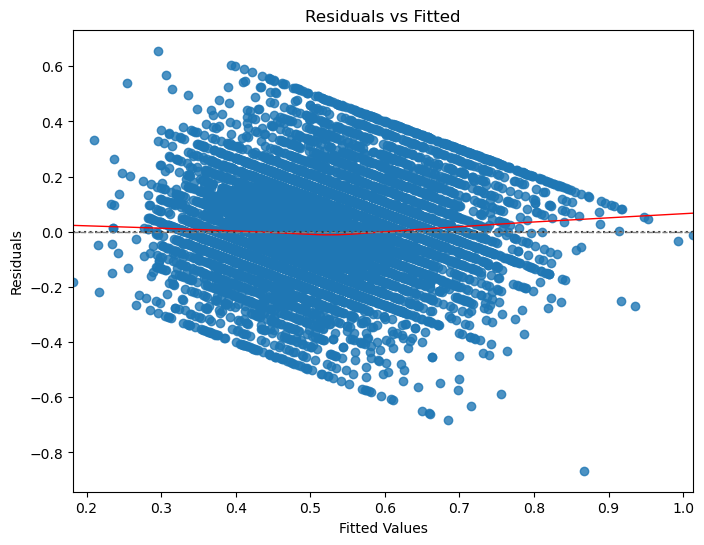

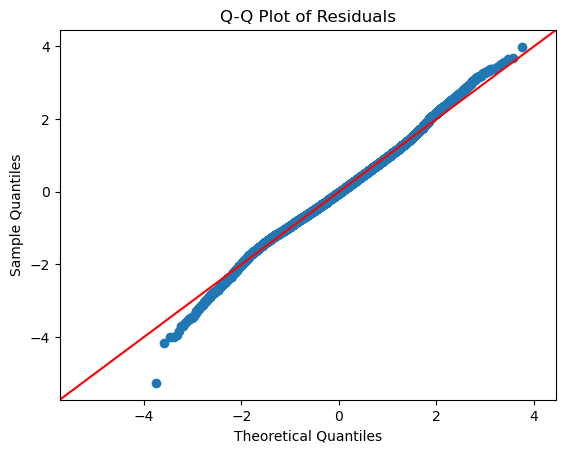

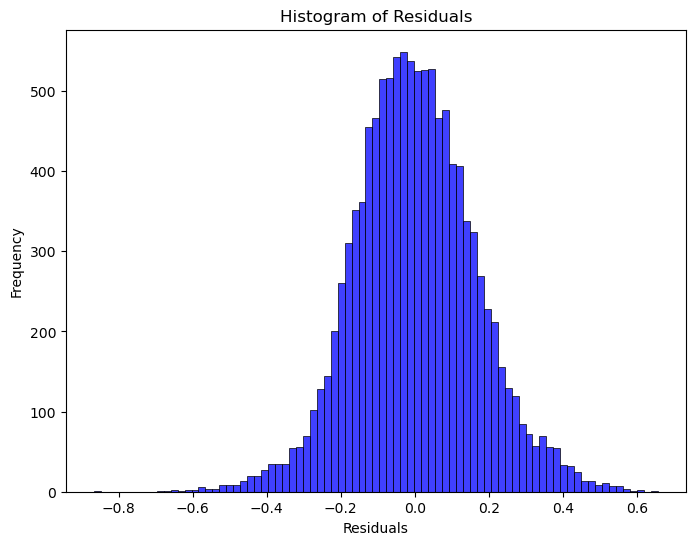

In [28]:
plots(ols_model_robust)

# WPFI Rank

In [51]:
df = pd.read_csv('data/wvs/wave7.csv')

# Define the list of countries to include
countries_to_keep = ['AUS','CAN','DEU','NLD','USA']
# Filter the DataFrame
df = df[df['B_COUNTRY_ALPHA'].isin(countries_to_keep)].copy()

C:\Users\ekaba\AppData\Local\Temp\ipykernel_23328\1574816901.py:1: DtypeWarning: Columns (582,583,584) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wvs/wave7.csv')


## Baseline 

In [52]:
X = df.loc[:, 'baseline_corruption':]
X['wpfi_rank'] = df['wpfi_rank']
y = df['base_distrust_index']

In [31]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                             OLS Regression Results                            
Dep. Variable:     base_distrust_index   R-squared:                       0.273
Model:                             OLS   Adj. R-squared:                  0.271
Method:                  Least Squares   F-statistic:                     104.0
Date:                 Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                         12:49:16   Log-Likelihood:                 7672.9
No. Observations:                11512   AIC:                        -1.527e+04
Df Residuals:                    11476   BIC:                        -1.501e+04
Df Model:                           35                                         
Covariance Type:                   HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

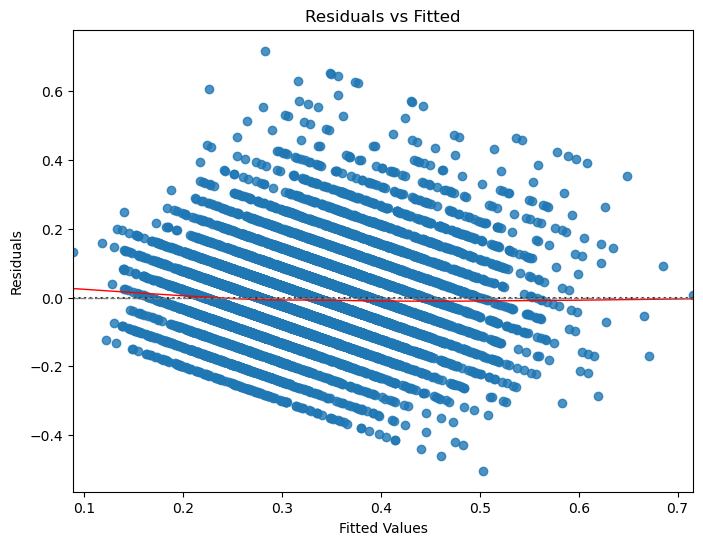

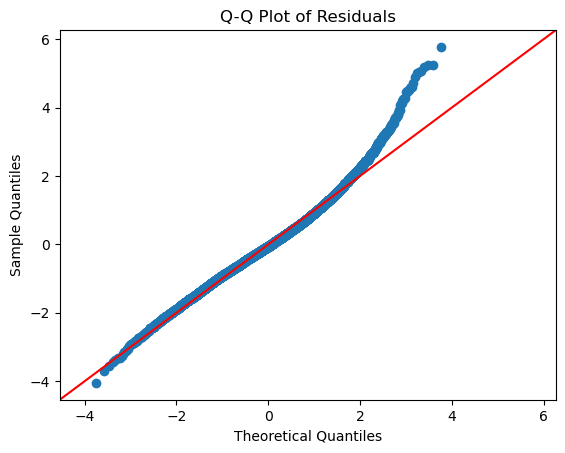

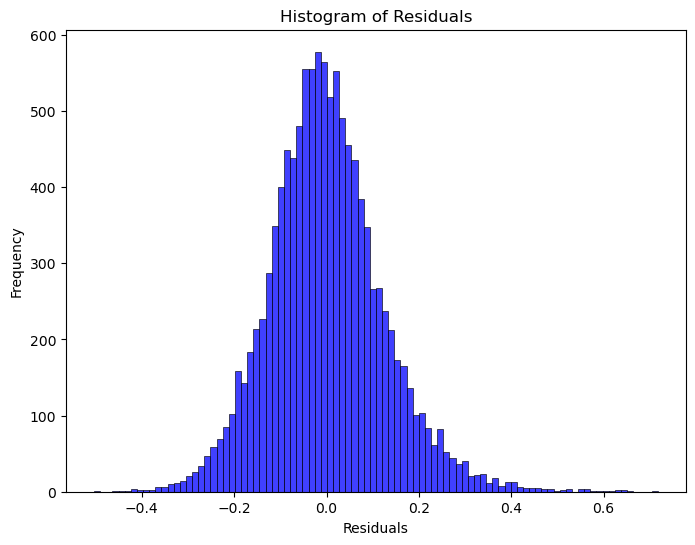

In [32]:
plots(ols_model_robust)

## National

In [50]:
df.wpfi_rank.value_counts()

wpfi_rank
16.0    4018
43.0    2342
28.0    1929
19.0    1733
15.0    1490
Name: count, dtype: int64

In [ ]:
df

In [56]:
X = df.loc[:, 'baseline_corruption':]
y = df['national_distrust_index']
X['wpfi_rank'] = df['wpfi_rank']*0.01


In [57]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                               OLS Regression Results                              
Dep. Variable:     national_distrust_index   R-squared:                       0.327
Model:                                 OLS   Adj. R-squared:                  0.325
Method:                      Least Squares   F-statistic:                     145.8
Date:                      Di, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                             14:43:26   Log-Likelihood:                 8122.2
No. Observations:                    11512   AIC:                        -1.617e+04
Df Residuals:                        11476   BIC:                        -1.591e+04
Df Model:                               35                                         
Covariance Type:                       HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

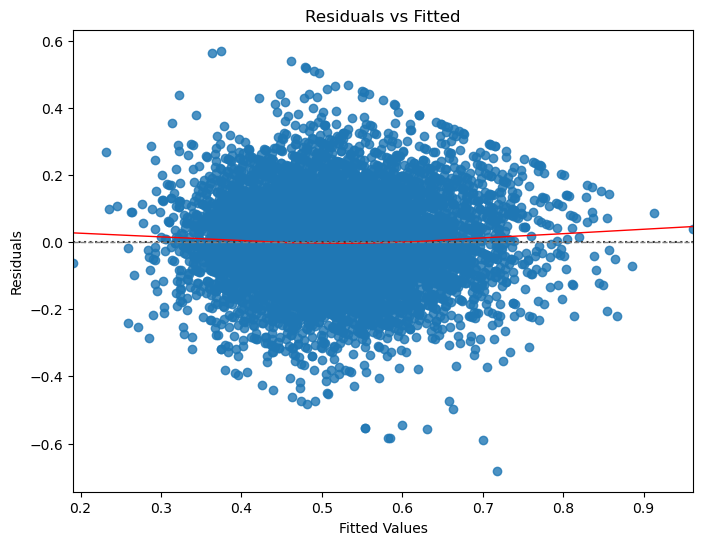

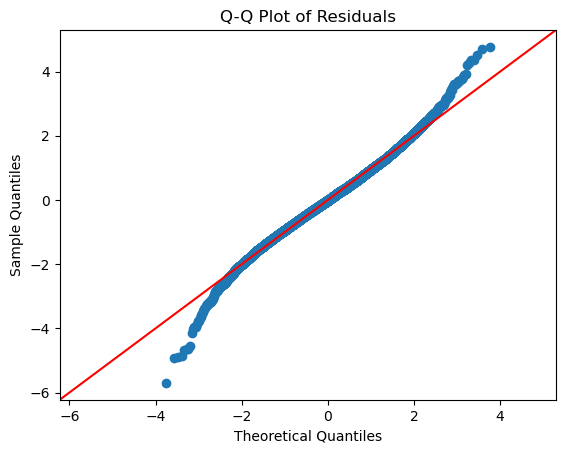

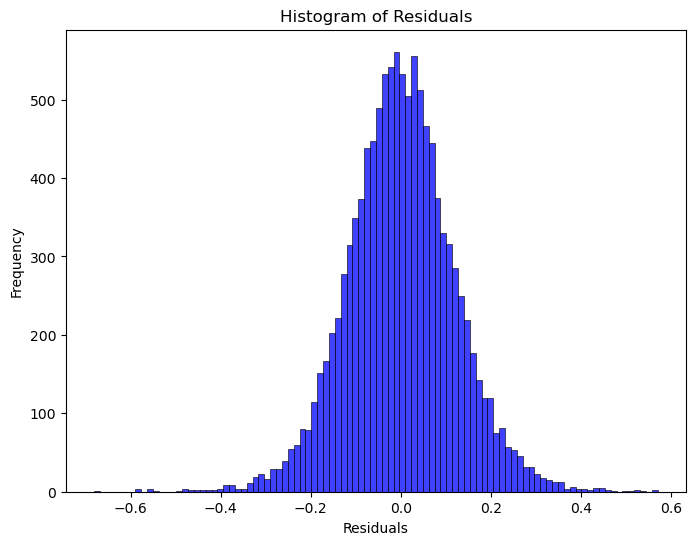

In [55]:
plots(ols_model_robust)

## International

In [36]:
X = df.loc[:, 'baseline_corruption':]
y = df['international_distrust_index']
X['wpfi_rank'] = df['wpfi_rank']

In [37]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                                 OLS Regression Results                                 
Dep. Variable:     international_distrust_index   R-squared:                       0.258
Model:                                      OLS   Adj. R-squared:                  0.256
Method:                           Least Squares   F-statistic:                     110.7
Date:                          Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                                  12:49:58   Log-Likelihood:                 4397.7
No. Observations:                         11512   AIC:                            -8723.
Df Residuals:                             11476   BIC:                            -8459.
Df Model:                                    35                                         
Covariance Type:                            HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

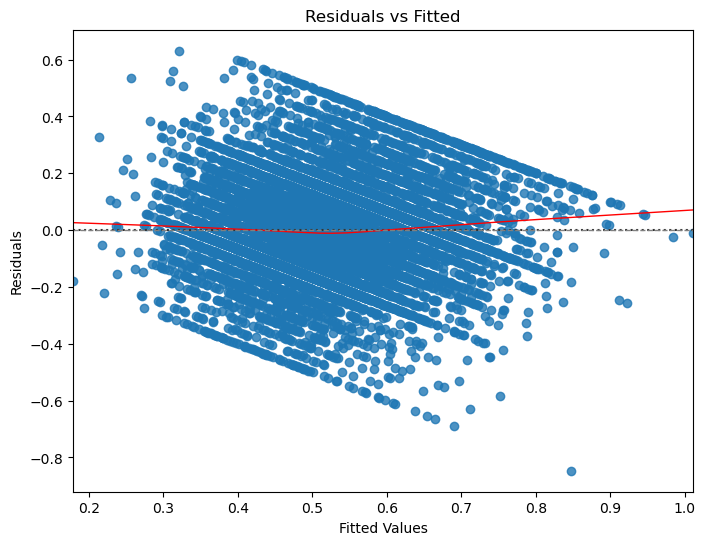

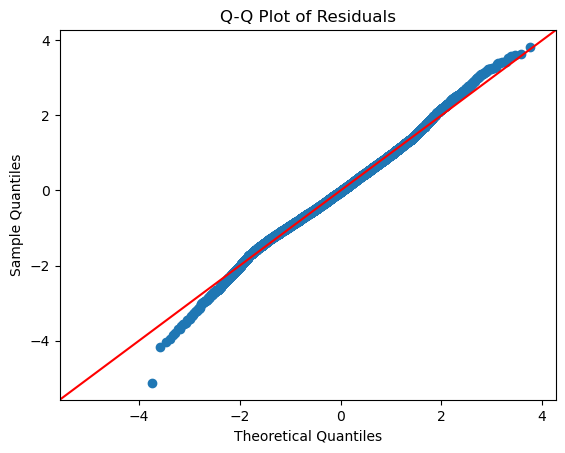

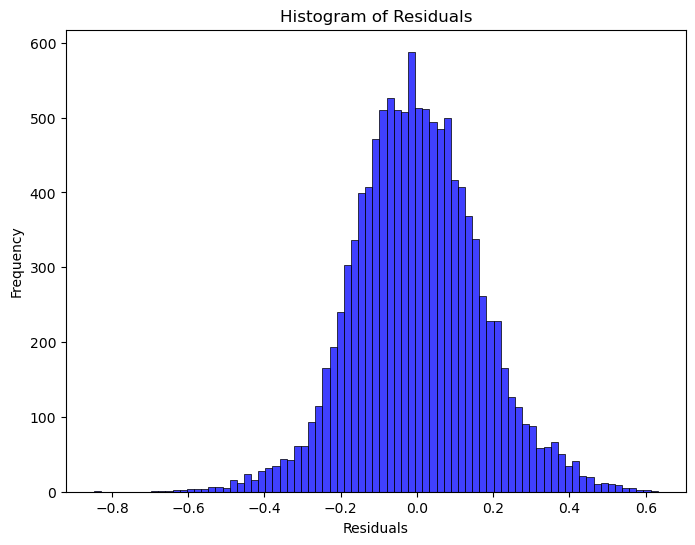

In [38]:
plots(ols_model_robust)

# DUMMY WPFI COUNTRY TEST

In [39]:
df = pd.read_csv('data/wvs/wave7.csv')

# Define the list of countries to include
countries_to_keep = ['AUS','CAN','DEU','NLD','USA']
# Filter the DataFrame
df = df[df['B_COUNTRY_ALPHA'].isin(countries_to_keep)].copy()

dummies = pd.get_dummies(df['B_COUNTRY_ALPHA'], prefix='country').astype(int)
df = pd.concat([df, dummies], axis=1)
df = df.drop(['country_DEU'], axis=1)

C:\Users\ekaba\AppData\Local\Temp\ipykernel_23328\1747683900.py:1: DtypeWarning: Columns (582,583,584) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wvs/wave7.csv')


In [40]:
df['wpfi_AUS'] = df['wpfi_rank']*df['country_AUS']
df['wpfi_CAN'] = df['wpfi_rank']*df['country_CAN']
df['wpfi_NLD'] = df['wpfi_rank']*df['country_NLD']
df['wpfi_USA'] = df['wpfi_rank']*df['country_USA']

interactions = ['wpfi_AUS', 'wpfi_CAN', 'wpfi_NLD', 'wpfi_USA']

## Baseline

In [41]:
X = df.loc[:, 'baseline_corruption':'income_group']
#X['wpfi_rank'] = df['wpfi_rank']
X[interactions] = df[interactions]
y = df['base_distrust_index']

In [42]:
# Add a constant term to the model (for the intercept)
X_const = sm.add_constant(X)

# Fit OLS model with robust standard errors
ols_model_robust = sm.OLS(y, X_const).fit(cov_type='HC0')

# Print the regression results with robust standard errors
print(ols_model_robust.summary())

                             OLS Regression Results                            
Dep. Variable:     base_distrust_index   R-squared:                       0.309
Model:                             OLS   Adj. R-squared:                  0.307
Method:                  Least Squares   F-statistic:                     117.1
Date:                 Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                         12:50:19   Log-Likelihood:                 7964.1
No. Observations:                11512   AIC:                        -1.585e+04
Df Residuals:                    11473   BIC:                        -1.556e+04
Df Model:                           38                                         
Covariance Type:                   HC0                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

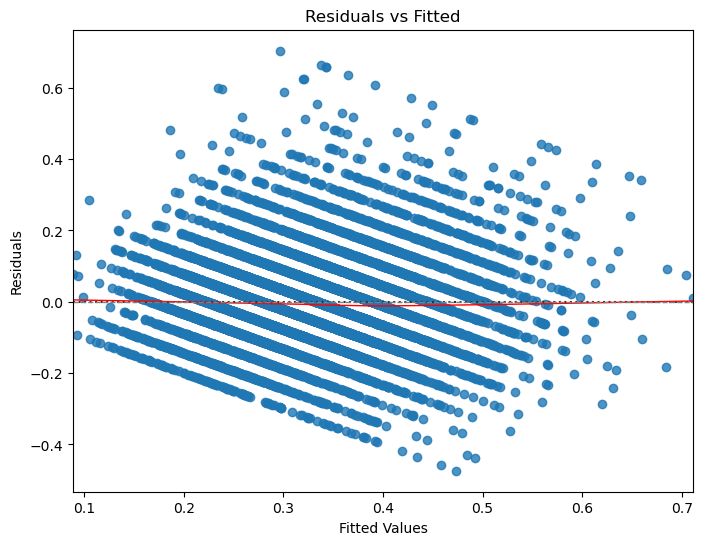

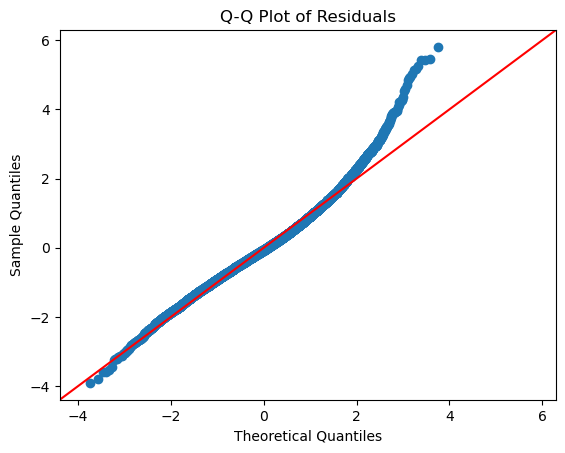

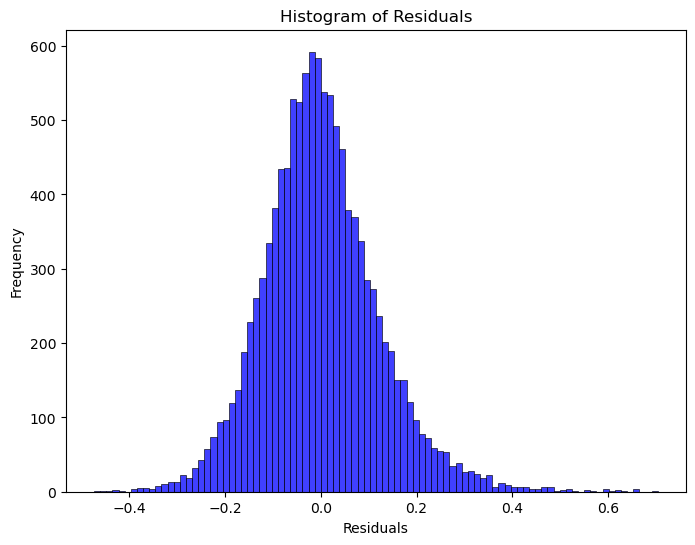

In [43]:
plots(ols_model_robust)